In [337]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

In [338]:
wti_data = pd.read_csv("https://raw.githubusercontent.com/easyyliu/mining_collections/main/wti.csv")
wti_data['Date'] = pd.to_datetime(wti_data['Date'])
wti_data = wti_data[(wti_data['Date'] >= '1998-01-01') & (wti_data['Date'] <= '2023-06-01')]
wti_data = wti_data.reset_index(drop=True)

In [339]:
ny_gasoline_data = pd.read_csv("https://raw.githubusercontent.com/easyyliu/mining_collections/main/ny_gasoline.csv")
ny_gasoline_data['Date'] = pd.to_datetime(ny_gasoline_data['Date'])
ny_gasoline_data = ny_gasoline_data[(ny_gasoline_data['Date'] >= '1998-01-01') & (ny_gasoline_data['Date'] <= '2023-06-01')]
ny_gasoline_data = ny_gasoline_data.reset_index(drop=True)

In [340]:
la_diesel_data = pd.read_csv("https://raw.githubusercontent.com/easyyliu/mining_collections/main/la_diesel.csv")
la_diesel_data['Date'] = pd.to_datetime(la_diesel_data['Date'])
la_diesel_data = la_diesel_data[(la_diesel_data['Date'] >= '1998-01-01') & (la_diesel_data['Date'] <= '2023-06-01')]
la_diesel_data = la_diesel_data.reset_index(drop=True)

In [341]:
heating_oil_data = pd.read_csv("https://raw.githubusercontent.com/easyyliu/mining_collections/main/ny_heating_oil.csv")
heating_oil_data['Date'] = pd.to_datetime(heating_oil_data['Date'])
heating_oil_data = heating_oil_data[(heating_oil_data['Date'] >= '1998-01-01') & (heating_oil_data['Date'] <= '2023-06-01')]
heating_oil_data.reset_index(drop=True, inplace=True)

In [342]:
x_propane_data = pd.read_csv("https://raw.githubusercontent.com/easyyliu/mining_collections/main/tx_propane.csv")
x_propane_data['Date'] = pd.to_datetime(x_propane_data['Date'])
x_propane_data = x_propane_data[(x_propane_data['Date'] >= '1998-01-01') & (x_propane_data['Date'] <= '2023-06-01')]
x_propane_data = x_propane_data.reset_index(drop=True)

In [343]:
merged_data = pd.merge(wti_data, ny_gasoline_data, on='Date', how='outer')
merged_data = pd.merge(merged_data, la_diesel_data, on='Date', how='outer')
merged_data = pd.merge(merged_data, heating_oil_data, on='Date', how='outer')
merged_data = pd.merge(merged_data, x_propane_data, on='Date', how='outer')

merged_data = merged_data.sort_values('Date')
merged_data['index'] = merged_data.reset_index().index
date_data = merged_data['Date']
merged_data = merged_data.drop('Date', axis=1)
merged_data = merged_data.apply(pd.to_numeric, errors='coerce')
imputer = KNNImputer(n_neighbors=3)
merged_data = imputer.fit_transform(merged_data)
merged_data = pd.DataFrame(merged_data, columns=['wti', 'ny gasoline', 'la diesel', 'ny heating oil', 'tx propane','index'])
merged_data = merged_data.sort_values('index')
date_data = date_data.sort_values()
sorted_date = date_data.reset_index(drop=True)
merged_data['date'] = sorted_date
merged_data = merged_data.drop('index', axis=1)
merged_data = merged_data.reindex(columns=['date', 'wti', 'ny gasoline', 'la diesel', 'ny heating oil', 'tx propane'])
merged_data = merged_data.sort_values('date')
merged_data.head()

,date,wti,ny gasoline,la diesel,ny heating oil,tx propane
0,1998-01-02,17.41,0.496,0.620,0.488,0.328
1,1998-01-05,16.95,0.482,0.595,0.475,0.320
2,1998-01-06,16.64,0.477,0.600,0.465,0.331
3,1998-01-07,16.91,0.483,0.585,0.467,0.309
4,1998-01-08,17.01,0.494,0.585,0.471,0.314


In [344]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

df = merged_data
df['Date_Ordinal'] = df['date'].apply(lambda x: x.toordinal())

# split to create 4 train_test groups between crude oil and refined petroleum products
X = df[['Date_Ordinal', 'wti']]
y_gasoline = df['ny gasoline']
y_diesel = df['la diesel']
y_heating = df['ny heating oil']
y_propane = df['tx propane']

In [345]:
from datetime import datetime
# Split dataset into training set and test set
train_size = int(0.8 * len(df))

temp_date = df['date']
dates_test = temp_date[train_size:]

X_train = X[:train_size]
X_test = X[train_size:]
y_gasoline_train = y_gasoline[:train_size]
y_gasoline_test = y_gasoline[train_size:]
y_diesel_train = y_diesel[:train_size]
y_diesel_test = y_diesel[train_size:]
y_heating_train = y_heating[:train_size]
y_heating_test = y_heating[train_size:]
y_propane_train = y_heating[:train_size]
y_propane_test = y_heating[train_size:]

mae_rmse_df = pd.DataFrame(columns=['petroleum','model','MAE', 'RMSE'])

In [346]:
def train_framework(X_train, X_test, y_train, y_test, petroleum):
    #for price training
    model_GBR = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=0)
    model_GBR.fit(X_train, y_train)
    y_pred_GBR = model_GBR.predict(X_test)

    model_RF = RandomForestRegressor(n_estimators=200, random_state=0, min_samples_leaf=2, min_samples_split=10)
    model_RF.fit(X_train, y_train)
    y_pred_RF = model_RF.predict(X_test)

    model_LR = LinearRegression()
    model_LR.fit(X_train, y_train)
    y_pred_LR = model_LR.predict(X_test)

    model_DT  = DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_leaf=4, min_samples_split=2)
    model_DT .fit(X_train, y_train)
    y_pred_DT  = model_DT.predict(X_test)

    # Mean Absolute Error (MAE)
    # Root Mean Squared Error (RMSE)
    n = mae_rmse_df.shape[0]

    mae_rmse_df.loc[n] = [petroleum, 'GradientBoostingRegressor',
                      mean_absolute_error(y_test, y_pred_GBR),
                      np.sqrt(mean_squared_error(y_test, y_pred_GBR))]

    mae_rmse_df.loc[n+1] = [petroleum, 'RandomForestRegressor',
                      mean_absolute_error(y_test, y_pred_RF),
                      np.sqrt(mean_squared_error(y_test, y_pred_RF))]

    mae_rmse_df.loc[n+2] = [petroleum, 'LinearRegression',
                      mean_absolute_error(y_test, y_pred_LR),
                      np.sqrt(mean_squared_error(y_test, y_pred_LR))]

    mae_rmse_df.loc[n+3] = [petroleum, 'DecisionTreeRegressor',
                      mean_absolute_error(y_test, y_pred_DT),
                      np.sqrt(mean_squared_error(y_test, y_pred_DT))]

    #draw comparison graph
    fig, ax = plt.subplots(figsize=(10, 6))
    label1 = 'Actual '+ petroleum +' Price'
    label2 = 'Actual vs Predicted ' + petroleum +' Price'
    ax.plot(dates_test, y_test, label=label1)
    ax.plot(dates_test, y_pred_GBR, label='Gradient Boosting Regressor Predicted Price')
    ax.plot(dates_test, y_pred_RF, label='Random Forest RegressorPredicted Price')
    ax.plot(dates_test, y_pred_LR, label='Linear Regression Predicted Price')
    ax.plot(dates_test, y_pred_DT, label='Decision Tree Predicted Price')


    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.set_title(label2)
    plt.show()

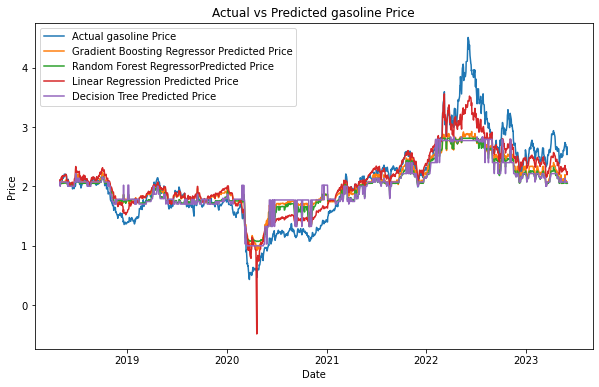

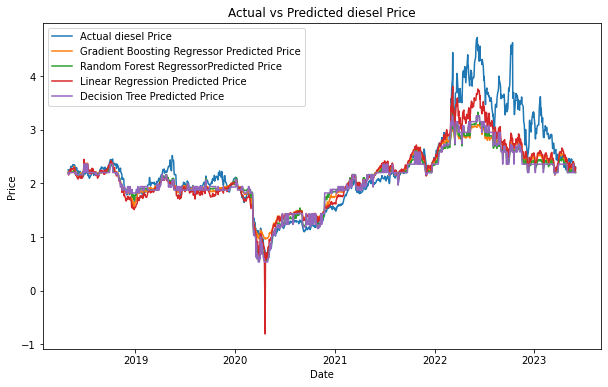

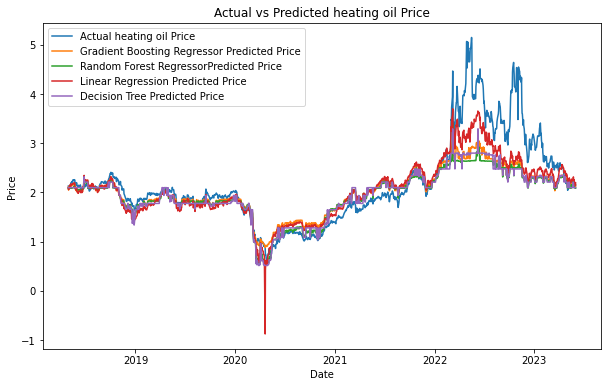

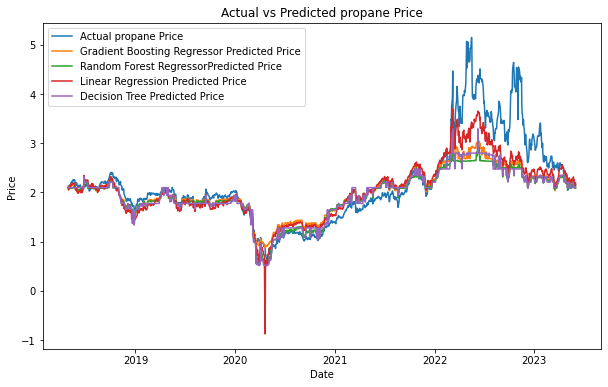

,petroleum,model,MAE,RMSE
0,gasoline,GradientBoostingRegressor,0.260327,0.358040
1,gasoline,RandomForestRegressor,0.269127,0.365222
2,gasoline,LinearRegression,0.167314,0.227458
3,gasoline,DecisionTreeRegressor,0.284086,0.386102
4,diesel,GradientBoostingRegressor,0.257143,0.419360
5,diesel,RandomForestRegressor,0.264121,0.429838
6,diesel,LinearRegression,0.224623,0.342223
7,diesel,DecisionTreeRegressor,0.269898,0.429405
8,heating oil,GradientBoostingRegressor,0.311420,0.520070
9,heating oil,RandomForestRegressor,0.321237,0.557511


In [347]:
train_framework(X_train, X_test, y_gasoline_train, y_gasoline_test, 'gasoline')
train_framework(X_train, X_test, y_diesel_train, y_diesel_test, 'diesel')
train_framework(X_train, X_test, y_heating_train, y_heating_test, 'heating oil')
train_framework(X_train, X_test, y_propane_train, y_propane_test, 'propane')
mae_rmse_df